# Sales Analysis 

In this notebook I try to answer business questions about 12 months worth of sales data. The data contains hundreds of thousands of electronics store purchases broken down by month, product type, cost, purchase address, etc. The data is provided as 12 seperate csv files. The packages I shall be using are Python Pandas and Python Matpltolib. 

I start by cleaning up some of our data, this involves:

- Dropping Missing(NaN) values from the Dataframe. 
- Removing rows based upon certain conditions. 
- Changing the data type of columns. 

Once the data has been tidied, I will explore 5 business related questions: 

- What was the best month for sales? How much was earned that month?
- What city sold the most product?
- What time should I display advertisemens to maximize the likelihood of customer’s buying product?
- What products are most often sold together?
- What product sold the most? Why I think it sold the most?

Credit: The data and tasks have been provided by a Youtuber: Keith Galli, this purpose of this task was to familiarise myself more with pandas and apply my knowledge to real data. 


### Importing Modules

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import os 
import calendar

Data is provided as 12 months of sales data in 12 seperate files, hence I'd like to merge them all into a single dataframe. 

In [4]:
merged_data = pd.DataFrame()

for file in os.listdir('./Sales_Data'):
    new_data = pd.read_csv(f'./Sales_Data/{file}')
    merged_data = pd.concat([merged_data, new_data], ignore_index=True)

# Lets save our merged data as it's useful to have:
merged_data.to_csv('All_Months_Data.csv', index=False)

Read in the 12 months CSV that we have just created:

In [5]:
all_data = pd.read_csv('All_Months_Data.csv')

### Cleaning Data:

First we remove all rows where we have any NaN values and we remove the repeated column names that appear in our data. 

In [6]:

all_data.dropna(axis=0, inplace=True)

all_data = all_data.loc[all_data['Order ID'] != 'Order ID']

all_data = all_data.reset_index(drop=True)

Save our clean Data.

In [7]:
clean_data = all_data.to_csv('CleanData.csv', index=False)

### Tidying Data:

Read in our clean data.

In [8]:
clean_data = pd.read_csv('CleanData.csv')

Some information is lost once merging the data, in particular, the month each data entry is from, hence I'll add a column to state the month (Numerically).

In [9]:
# The following splits up the 'Order Date' of each entry, then accesses the first 2 digits, ie the month and creates a new month column from that. 

clean_data['Month'] = clean_data['Order Date'].str.split('/', expand=True)[0]

clean_data['Month'] = pd.to_numeric(clean_data['Month'])

clean_data.head(6)


,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month
0,295665,Macbook Pro Laptop,1,1700.00,12/30/19 00:01,"136 Church St, New York City, NY 10001",12
1,295666,LG Washing Machine,1,600.00,12/29/19 07:03,"562 2nd St, New York City, NY 10001",12
2,295667,USB-C Charging Cable,1,11.95,12/12/19 18:21,"277 Main St, New York City, NY 10001",12
3,295668,27in FHD Monitor,1,149.99,12/22/19 15:13,"410 6th St, San Francisco, CA 94016",12
4,295669,USB-C Charging Cable,1,11.95,12/18/19 12:38,"43 Hill St, Atlanta, GA 30301",12
5,295670,AA Batteries (4-pack),1,3.84,12/31/19 22:58,"200 Jefferson St, New York City, NY 10001",12


#### Question 1: What was the best month for Sales and how much was earned in that Month?

To answer this question, I can use the Pandas GroupBy method to gain statistics about the monthly data. Before I group by the month, I first need a new column to represent the order total, as currently we only have the cost per item and the quantity ordered. Summing the price by month doesn't take into account the multiple quantities

Creating New Columns for Order Total, for readability I shall add the column next to the price. 

In [10]:
totals = clean_data['Quantity Ordered'].multiply(clean_data['Price Each'])

clean_data.insert(4,'Total', totals) 


In [11]:
monthly_totals = clean_data.groupby(['Month']).sum()['Total']

monthly_sorted = pd.DataFrame(monthly_totals).sort_values('Total', ascending=False)

monthly_sorted


,Total
Month,
12,4613443.34
10,3736726.88
4,3390670.24
11,3199603.20
5,3152606.75
3,2807100.38
7,2647775.76
6,2577802.26
8,2244467.88


Let's Create a plot depicting the monthly totals:

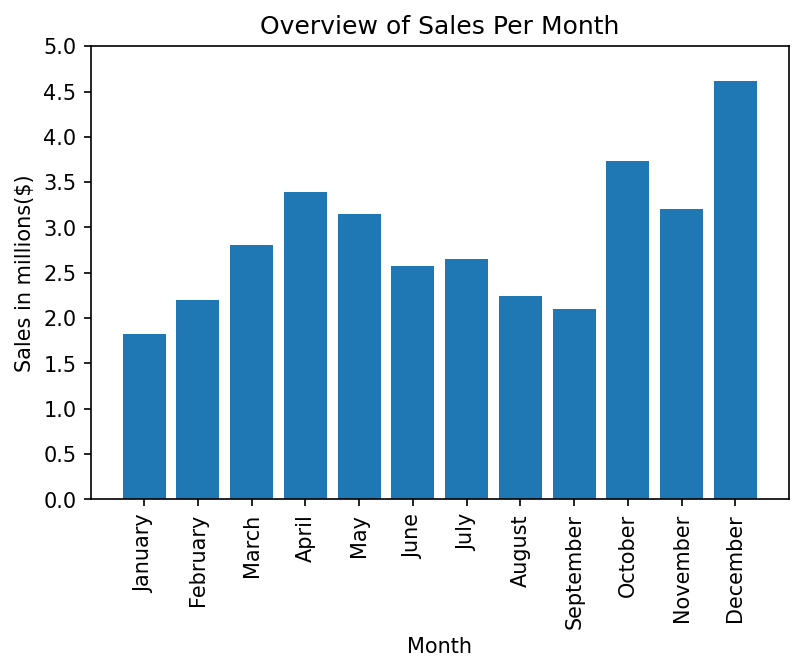

In [12]:
plt.figure(dpi=150)
word_months = [calendar.month_name[i] for i in range(1,13)]
month_totals = monthly_totals.divide(1000000)
plt.xlabel('Month')
plt.ylabel('Sales in millions($)')
plt.title('Overview of Sales Per Month')
plt.bar(word_months,month_totals)
plt.xticks(word_months, rotation=90)
plt.yticks(np.arange(0,5.5,0.5))
plt.show()

### Question 1 Answer: From this we can see that the most profitable month was December, with total sales = £4613443.34

### Question 2: What City had the highest number of Sales? 

To answer this question, I need to add a City column and a State Column, which can be extracted from the Address line in our table. 
We need both city and state as some cities have the same name but belong on different states. An example of this in our dataset is Portland, which occures in States: Oregon and Maine.  

In [13]:
# To obtain the city code, I split the address up based upon commas. I then take the middle string in that list, which is the City, I then also extract the State code from the address column. 

#Private method, used in "apply" method of a dataframe. 
def _get_state(x):
    return x.split(', ')[-1][:2]

def _get_city(x):
    return x.split(', ')[-2]

city =  clean_data['Purchase Address'].apply(lambda x: f'{_get_city(x)} ({_get_state(x)})')

clean_data['City'] = city

clean_data.head(6)

,Order ID,Product,Quantity Ordered,Price Each,Total,Order Date,Purchase Address,Month,City
0,295665,Macbook Pro Laptop,1,1700.00,1700.00,12/30/19 00:01,"136 Church St, New York City, NY 10001",12,New York City (NY)
1,295666,LG Washing Machine,1,600.00,600.00,12/29/19 07:03,"562 2nd St, New York City, NY 10001",12,New York City (NY)
2,295667,USB-C Charging Cable,1,11.95,11.95,12/12/19 18:21,"277 Main St, New York City, NY 10001",12,New York City (NY)
3,295668,27in FHD Monitor,1,149.99,149.99,12/22/19 15:13,"410 6th St, San Francisco, CA 94016",12,San Francisco (CA)
4,295669,USB-C Charging Cable,1,11.95,11.95,12/18/19 12:38,"43 Hill St, Atlanta, GA 30301",12,Atlanta (GA)
5,295670,AA Batteries (4-pack),1,3.84,3.84,12/31/19 22:58,"200 Jefferson St, New York City, NY 10001",12,New York City (NY)


Now I need to Group the data based upon City and State, and then sort for highest sales first

In [14]:
# Note that in city_sales, the cities will be sorted alphabetically. 

city_sales = pd.DataFrame(clean_data.groupby(by='City', sort=True).sum()['Total'])

city_sales_sorted = city_sales.sort_values(by='Total', ascending=False)

city_sales

,Total
City,
Atlanta (GA),2795498.58
Austin (TX),1819581.75
Boston (MA),3661642.01
Dallas (TX),2767975.40
Los Angeles (CA),5452570.80
New York City (NY),4664317.43
Portland (ME),449758.27
Portland (OR),1870732.34
San Francisco (CA),8262203.91


Let's Create a plot depicting the sales based upon Cities: 

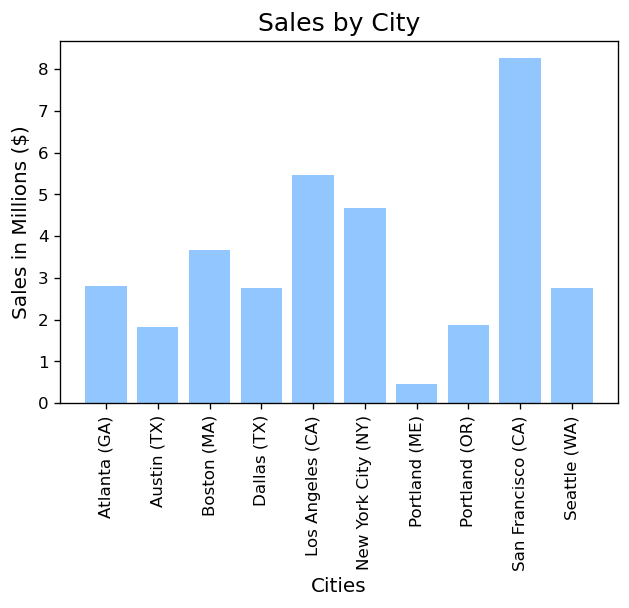

In [15]:
cities = clean_data['City'].unique()
cities.sort()
sales_in_mill = city_sales['Total'].divide(1000000)

plt.style.use('seaborn-pastel')
plt.figure(dpi=120)
plt.bar(cities, sales_in_mill)
plt.xlabel('Cities',size=12)
plt.ylabel('Sales in Millions ($)',size=12)
plt.title('Sales by City',size=15)
plt.xticks(cities, rotation=90,size=10)
plt.yticks(np.arange(0,9),size=10)
plt.show()


### Question 2 Answer: We can see that the city with the most sales is San Francisco (CA). 

### Question 3: What time should I display advertisements to maximize likelihpod of a customer buying products?

To answer this question, I'll extract the time at which orders were placed, then I will count the frequency of orders in each hour. 
I will do this based upon which hour the order time is closest to. For example, if an order was placed at 19:37, then this is closer to 20th hour than it is to 19th hour of the day, hence I will classify this as an order placed on the 20th hour. 

Convert 'Order Date' column into a python date and then create columns for the hour and minute of each order. 

In [30]:
clean_data['Order Date'] = pd.to_datetime(clean_data['Order Date'])

clean_data['Time'] = clean_data['Order Date'].dt.time

clean_data.head(6)


,Order ID,Product,Quantity Ordered,Price Each,Total,Order Date,Purchase Address,Month,City,Time
0,295665,Macbook Pro Laptop,1,1700.00,1700.00,2019-12-30 00:01:00,"136 Church St, New York City, NY 10001",12,New York City (NY),00:01:00
1,295666,LG Washing Machine,1,600.00,600.00,2019-12-29 07:03:00,"562 2nd St, New York City, NY 10001",12,New York City (NY),07:03:00
2,295667,USB-C Charging Cable,1,11.95,11.95,2019-12-12 18:21:00,"277 Main St, New York City, NY 10001",12,New York City (NY),18:21:00
3,295668,27in FHD Monitor,1,149.99,149.99,2019-12-22 15:13:00,"410 6th St, San Francisco, CA 94016",12,San Francisco (CA),15:13:00
4,295669,USB-C Charging Cable,1,11.95,11.95,2019-12-18 12:38:00,"43 Hill St, Atlanta, GA 30301",12,Atlanta (GA),12:38:00
5,295670,AA Batteries (4-pack),1,3.84,3.84,2019-12-31 22:58:00,"200 Jefferson St, New York City, NY 10001",12,New York City (NY),22:58:00


Extract the hours and count the number of times an order was placed at a particular hour. 

In [ ]:
# Store occurences of each hour in a dictionary, initialising the dictionary below. 
time_of_orders = {j : 0 for j in range(0, 24)}

# For each order we need to see which hour the order was placed. 
for time in clean_data['Time']:
    # Hour and minute at which order was placed. 
    hour = time.hour
    minute = time.minute
    #If the minute is past the half past mark, classify as the next hour, else we count this as the same hour. 
    if minute > 30:
        if hour == 23:
            time_of_orders[0] += 1 
        else:
            time_of_orders[hour+1] +=1 
    elif minute <= 30:
        time_of_orders[hour] += 1 



Create a Plot for a visual represenation:

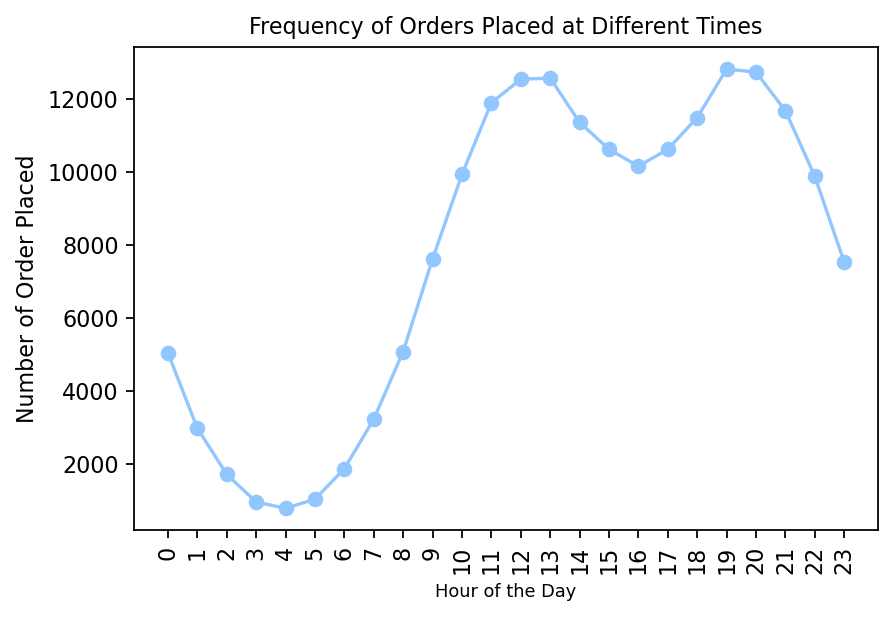

In [47]:
plt.figure(dpi=160)

plt.plot(time_of_orders.keys(), time_of_orders.values(),marker='o')
plt.ylabel('Number of Order Placed')
plt.xlabel('Hour of the Day',size=8)
plt.title('Frequency of Orders Placed at Different Times', size=10)
plt.xticks(range(0,24), rotation=90)
plt.show()

Question 3 Answer: Based on this plot we can see that 11:30-13:30 and 18:30-20:30 are the times of the day where the largest proportion orders are placed. So I'd recommend to the shop, to place advertisements during these times to target customers. 